# Pytorch model framework for A15 Phase prediction


## Packages

In [4]:
import torch
import torchvision
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import pandas as pd
import numpy as np
from os import listdir
from PIL import Image
import optuna
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

# Data

## Loading

In [5]:
# Load data
df = pd.read_csv('/home/lukas/Masterthesis/data/00_raw/Phasenanteile_ges.csv')

# Get the list of image files
image_folder = '/home/lukas/Masterthesis/data/02_resize-convert'  # Adjust this path

print(image_folder)
print(df.head())

/home/lukas/Masterthesis/data/02_resize-convert
                                   name  A15 Phase  Chromium  Silicon  \
0  F006_044_Detail1_500x20kV_oan_M1.tif      55.02      66.3     10.8   
1  F006_044_Detail2_500x20kV_oan_M2.tif      54.59      66.3     10.8   
2  F006_044_Detail3_500x20kV_oan_M3.tif      54.12      66.3     10.8   
3  F006_044_Detail4_500x20kV_oan_M4.tif      50.51      66.3     10.8   
4  F006_044_Detail5_500x20kV_oan_M5.tif      55.92      66.3     10.8   

   Germanium  Molybdenum  Platinum  
0        1.7        21.3       0.0  
1        1.7        21.3       0.0  
2        1.7        21.3       0.0  
3        1.7        21.3       0.0  
4        1.7        21.3       0.0  


In [6]:
image_path = "/home/lukas/Masterthesis/data/02_resize-convert/F006_039_Detail4_500x20kV_oan_M4.tif"
img = Image.open(image_path)

print("image format: ", img.format)
print("image mode: ", img.mode)
print("image size: ", img.size) 

img.show()

image format:  TIFF
image mode:  L
image size:  (224, 224)



(eog:371236): Gtk-WARNING **: 10:05:45.700: cannot open display: 


## Train Test Split

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import random


image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.tif'))]

# Ensure that all image files have corresponding composition data
df = df[df.iloc[:, 0].isin(image_files)]

# Perform the train-test split
train_val_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)

print(train_data.shape, test_data.shape, val_data.shape)
print(train_data.head(), test_data.head(), val_data.head())
print(f"the length of the image files folder is: ",len(image_files))  

(57, 7) (20, 7) (20, 7)
                                    name  A15 Phase  Chromium  Silicon  \
3   F006_044_Detail4_500x20kV_oan_M4.tif      50.51      66.3     10.8   
96     F012_032_Detail11_2kx20kV_A33.tif      19.39      90.6      9.4   
56                       F690_108_M5.tif      33.00      90.9      9.1   
69                       F690_111_M3.tif      31.10      90.7      7.0   
2   F006_044_Detail3_500x20kV_oan_M3.tif      54.12      66.3     10.8   

    Germanium  Molybdenum  Platinum  
3         1.7        21.3       0.0  
96        0.0         0.0       0.0  
56        0.0         0.0       0.0  
69        2.2         0.0       0.0  
2         1.7        21.3       0.0                                       name  A15 Phase  Chromium  Silicon  \
62                       F690_122_M1.tif      23.90     89.90     7.80   
40        F011_015_11_1kx20kV_com_M2.tif      13.51     88.91     7.51   
93     F012_032_Detail10_2kx20kV_A30.tif      28.39     90.60     9.40   
18  F00

## Copy Imgs to destinations

In [8]:
import os 
import pandas as pd
import shutil

source_folder = "/home/lukas/Masterthesis/data/02_resize-convert"
train_destination_folder = "/home/lukas/Masterthesis/pytorch/data/train"
test_destination_folder = "/home/lukas/Masterthesis/pytorch/data/test"
val_destination_folder = "/home/lukas/Masterthesis/pytorch/data/val"

# Create the destination folders if they do not exist
if not os.path.exists(train_destination_folder):
    os.makedirs(train_destination_folder)
if not os.path.exists(test_destination_folder):
    os.makedirs(test_destination_folder)
if not os.path.exists(val_destination_folder):
    os.makedirs(val_destination_folder)

all_images = os.listdir(source_folder)

# Train img
images_to_copy = [img for img in all_images if img in train_data['name'].values]

for image in images_to_copy:
    source_path = os.path.join(source_folder, image)
    destination_path = os.path.join(train_destination_folder, image)
    shutil.copy(source_path, destination_path)

print(f"Copied {len(images_to_copy)} images to {train_destination_folder}.")

# Test img
images_to_copy = [img for img in all_images if img in test_data['name'].values]
for image in images_to_copy:
    source_path = os.path.join(source_folder, image)
    destination_path = os.path.join(test_destination_folder, image)
    shutil.copy(source_path, destination_path)

print(f"Copied {len(images_to_copy)} images to {test_destination_folder}.")

# Val img
images_to_copy = [img for img in all_images if img in val_data['name'].values]
for image in images_to_copy:
    source_path = os.path.join(source_folder, image)
    destination_path = os.path.join(val_destination_folder, image)
    shutil.copy(source_path, destination_path)

print(f"Copied {len(images_to_copy)} images to {val_destination_folder}.")

Copied 57 images to /home/lukas/Masterthesis/pytorch/data/train.
Copied 20 images to /home/lukas/Masterthesis/pytorch/data/test.
Copied 20 images to /home/lukas/Masterthesis/pytorch/data/val.


In [9]:
# Check if images are also listed in the dataframes


# Check train folder
print("Checking training images:")
for img in os.listdir(train_destination_folder):
    if img not in train_data['name'].values:
        print(f"Train image not in dataframe: {img}")
    else:
        print(f"Train image in dataframe: {img}")

# Check test folder
print("\nChecking test images:")
for img in os.listdir(test_destination_folder):
    if img not in test_data['name'].values:
        print(f"Test image not in dataframe: {img}")
    else:
        print(f"Test image in dataframe: {img}")

# Check validation folder (may be empty)
print("\nChecking validation images:")
for img in os.listdir(val_destination_folder):
    if img not in val_data['name'].values:
        print(f"Validation image not in dataframe: {img}")
    else:
        print(f"Validation image in dataframe: {img}")

        

Checking training images:
Train image in dataframe: F012_024_Detail2_1kx20kV_A50.tif
Train image in dataframe: F006_041_Detail2_500x20kV_oan_M2.tif
Train image in dataframe: F011_010_1_1kx20kV_com_M3.tif
Train image in dataframe: F690_108_M1.tif
Train image in dataframe: F011_011_2_1kx20kV_com_M1.tif
Train image in dataframe: F690_108_M5.tif
Train image in dataframe: F006_040_Detail5_500x20kV_oan_M5.tif
Train image in dataframe: F006_044_Detail2_500x20kV_oan_M2.tif
Train image in dataframe: F690_111_M3.tif
Train image in dataframe: F006_040_Detail1_500x20kV_oan_M1.tif
Train image in dataframe: F011_013_11_1kx20kV_com_M1.tif
Train image in dataframe: F012_032_Detail10_2kx20kV_A29.tif
Train image in dataframe: F006_044_Detail3_500x20kV_oan_M3.tif
Train image in dataframe: F011_011_11_1kx20kV_com_M1.tif
Train image in dataframe: F012_051_Detail5_2kx20kV_A71.tif
Train image in dataframe: F006_044_Detail4_500x20kV_oan_M4.tif
Train image in dataframe: F690_111_M2.tif
Train image in dataframe

## Train Data Augmentation

### Augmentation for images

In [10]:
# Augementation for the images

def rotate_and_flip_images(input_folder, output_folder):
    """
    Rotates and flips images from the input folder, appending numbers 1-8 to the filenames.
    Saves all transformed images in the specified output folder.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created output directory: {output_folder}")
    else:
        print(f"Output directory already exists: {output_folder}")

    processed_count = 0

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            image_path = os.path.join(input_folder, filename)
            img = Image.open(image_path)

            # Define transformations
            transformations = [
                (img, "1"),  # Original
                (img.rotate(90, expand=True), "2"),
                (img.rotate(180, expand=True), "3"),
                (img.rotate(270, expand=True), "4"),
                (img.transpose(Image.FLIP_LEFT_RIGHT), "5"),
                (img.transpose(Image.FLIP_LEFT_RIGHT).rotate(90, expand=True), "6"),
                (img.transpose(Image.FLIP_LEFT_RIGHT).rotate(180, expand=True), "7"),
                (img.transpose(Image.FLIP_LEFT_RIGHT).rotate(270, expand=True), "8"),
            ]

            # Save transformed images
            for transformed_img, suffix in transformations:
                new_filename = f"{os.path.splitext(filename)[0]}_{suffix}.tif"
                transformed_img.save(os.path.join(output_folder, new_filename))
                processed_count += 1

    return processed_count

# Example usage
input_folder = '/home/lukas/Masterthesis/pytorch/data/train'  # Replace with your input folder path
output_folder = '/home/lukas/Masterthesis/pytorch/data/train_img_augmented'  # Replace with your desired output folder path

processed_images = rotate_and_flip_images(input_folder, output_folder)
print(f"Total images processed: {processed_images}")
print(f"Transformed images saved in: {output_folder}")


Output directory already exists: /home/lukas/Masterthesis/pytorch/data/train_img_augmented
Total images processed: 456
Transformed images saved in: /home/lukas/Masterthesis/pytorch/data/train_img_augmented


### Augmentation for dataframe

In [11]:
# Augmentation for the train_data dataframe

def replicated_df_rows(train_data):
    new_rows = []

    for index, row in train_data.iterrows():
        for i in range(1, 9):
            modified_row = row.copy()
            # Split the name into base and extension using rsplit
            name_parts = row['name'].rsplit('.', 1)
            if len(name_parts) == 2:
                base_name, extension = name_parts
                # Insert the number before the extension
                modified_row['name'] = f"{base_name}_{i}.{extension}"
            else:
                # If no extension is present, simply append the number
                modified_row['name'] = f"{row['name']}_{i}"
            new_rows.append(modified_row)
        
    return pd.DataFrame(new_rows)
    



train_data = replicated_df_rows(train_data)

print(train_data.shape)


(456, 7)


### Image-Path Creation

In [12]:
import pandas as pd
import os

train_folder = output_folder
test_folder = test_destination_folder
val_folder  = val_destination_folder

# Function to get the full path of an image
def get_image_path_train(filename):
    return os.path.join(train_folder, filename)
    
    # Add a new column 'image_path' with the full path to each image
train_data['image_path'] = train_data.iloc[:, 0].apply(get_image_path_train)
    
# Move 'image_path' column to the first position
cols = ['image_path'] + [col for col in train_data.columns if col != 'image_path']
train_data = train_data[cols]
    

print(train_data.shape)
print(train_data.head())


# Function to get the full path of an image
def get_image_path_test(filename):
    return os.path.join(test_folder, filename)

    # Add a new column 'image_path' with the full path to each image
test_data['image_path'] = test_data.iloc[:, 0].apply(get_image_path_test)
    
# Move 'image_path' column to the first position
cols = ['image_path'] + [col for col in test_data.columns if col != 'image_path']
test_data = test_data[cols]
    

# Function to get the full path of an image
def get_image_path_val(filename):
    return os.path.join(val_folder, filename)

    # Add a new column 'image_path' with the full path to each image
val_data['image_path'] = val_data.iloc[:, 0].apply(get_image_path_val)
    
# Move 'image_path' column to the first position
cols = ['image_path'] + [col for col in val_data.columns if col != 'image_path']
val_data = val_data[cols]
    
    
print(test_data.shape)
print(test_data.head())
print(val_data.shape)
print(val_data.head())

# df_train.to_csv('/home/lukas/Masterthesis/pytorch/train_data.csv', index=False)

(456, 8)
                                          image_path  \
3  /home/lukas/Masterthesis/pytorch/data/train_im...   
3  /home/lukas/Masterthesis/pytorch/data/train_im...   
3  /home/lukas/Masterthesis/pytorch/data/train_im...   
3  /home/lukas/Masterthesis/pytorch/data/train_im...   
3  /home/lukas/Masterthesis/pytorch/data/train_im...   

                                     name  A15 Phase  Chromium  Silicon  \
3  F006_044_Detail4_500x20kV_oan_M4_1.tif      50.51      66.3     10.8   
3  F006_044_Detail4_500x20kV_oan_M4_2.tif      50.51      66.3     10.8   
3  F006_044_Detail4_500x20kV_oan_M4_3.tif      50.51      66.3     10.8   
3  F006_044_Detail4_500x20kV_oan_M4_4.tif      50.51      66.3     10.8   
3  F006_044_Detail4_500x20kV_oan_M4_5.tif      50.51      66.3     10.8   

   Germanium  Molybdenum  Platinum  
3        1.7        21.3       0.0  
3        1.7        21.3       0.0  
3        1.7        21.3       0.0  
3        1.7        21.3       0.0  
3        1.7      

## Selector Vector

### Shuffeling

In [13]:
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
print("\nShuffled DataFrame:")
print(train_data.head())

test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)
print("\nShuffled DataFrame:")
print(test_data.head())

val_data = val_data.sample(frac=1, random_state=42).reset_index(drop=True)
print("\nShuffled DataFrame:")
print(val_data.head())


Shuffled DataFrame:
                                          image_path  \
0  /home/lukas/Masterthesis/pytorch/data/train_im...   
1  /home/lukas/Masterthesis/pytorch/data/train_im...   
2  /home/lukas/Masterthesis/pytorch/data/train_im...   
3  /home/lukas/Masterthesis/pytorch/data/train_im...   
4  /home/lukas/Masterthesis/pytorch/data/train_im...   

                                     name  A15 Phase  Chromium  Silicon  \
0  F006_039_Detail5_500x20kV_oan_M5_6.tif      31.41      88.9      9.1   
1  F006_044_Detail3_500x20kV_oan_M3_8.tif      54.12      66.3     10.8   
2      F012_051_Detail5_2kx20kV_A69_5.tif      13.09      90.4      7.8   
3      F012_051_Detail5_2kx20kV_A71_3.tif      12.60      90.4      7.8   
4  F006_040_Detail1_500x20kV_oan_M1_4.tif      10.35      87.9      6.4   

   Germanium  Molybdenum  Platinum  
0        0.0         2.0       0.0  
1        1.7        21.3       0.0  
2        1.8         0.0       0.0  
3        1.8         0.0       0.0  
4     

In [14]:
import pandas as pd
import numpy as np

def process_dataset(data, random_state=42):
    """
    Process a dataset by:
    1. Adding selector vectors
    2. Replicating rows for each composition type
    3. Shuffling the data
    4. Normalizing the value column
    
    Args:
        data (pd.DataFrame): Input dataframe to process
        random_state (int): Random seed for reproducibility
        
    Returns:
        pd.DataFrame: Processed dataframe
    """
    # Create initial selector vector and composition value
    sv = np.array([0, 0, 0, 0, 0, 0])
    data['selector_vector'] = data.apply(lambda x: sv, axis=1)
    data['composition_value'] = data.apply(lambda x: 0, axis=1)
    
    # Mapping dictionary for compositions
    mapping = {
        0: ("A15_Phase", "A15 Phase"),
        1: ("Chromium", "Chromium"),
        2: ("Silicon", "Silicon"),
        3: ('Germanium', 'Germanium'),
        4: ("Molybdenum", "Molybdenum"),
        5: ("Platinum", "Platinum")
    }
    
    # Helper function to modify selector vector
    def modify_selector_vector(row, index):
        selector = row['selector_vector'].copy()
        selector[:] = 0
        selector[index] = 1
        return selector
    
    # List to store replicated rows
    new_rows = []
    
    # Replicate each row for each composition type
    for idx, row in data.iterrows():
        for i in range(6):
            new_row = row.copy()
            new_row['selector_vector'] = modify_selector_vector(row, i)
            new_row['composition_value'] = 0
            new_row['Compo_name'] = mapping[i][0]
            new_row['value'] = row[mapping[i][1]]
            new_rows.append(new_row)
    
    # Create new dataframe and reset index
    processed_data = pd.DataFrame(new_rows).reset_index(drop=True)
    
    # Shuffle the data
    processed_data = processed_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    # Normalize the value column
    processed_data = normalize_column_to_range(processed_data, 'value')
    
    return processed_data

# Function to normalize a column to range [-1, 1]
def normalize_column_to_range(dataframe, column_name):
    col_min = 0
    col_max = 100
    dataframe[column_name] = -1 + 2 * (dataframe[column_name] - col_min) / (col_max - col_min)
    return dataframe

# Process each dataset
train_data = process_dataset(train_data)
test_data = process_dataset(test_data)
# save the test data to .csv
test_data.to_csv('/home/lukas/Masterthesis/pytorch/test_data.csv', index=False)
val_data = process_dataset(val_data)

# Print information about processed datasets
print(f'Train data length: {len(train_data)}')
print(f'Test data length: {len(test_data)}')
print(f'Validation data length: {len(val_data)}')

print("\nSample of processed train data:")
print(train_data.head())


Train data length: 2736
Test data length: 120
Validation data length: 120

Sample of processed train data:
                                          image_path  \
0  /home/lukas/Masterthesis/pytorch/data/train_im...   
1  /home/lukas/Masterthesis/pytorch/data/train_im...   
2  /home/lukas/Masterthesis/pytorch/data/train_im...   
3  /home/lukas/Masterthesis/pytorch/data/train_im...   
4  /home/lukas/Masterthesis/pytorch/data/train_im...   

                                     name  A15 Phase  Chromium  Silicon  \
0      F012_051_Detail1_2kx20kV_A56_1.tif      13.28      90.4      7.8   
1  F006_043_Detail3_500x20kV_oan_M3_4.tif      47.07      68.6      2.0   
2    F012_036_Detail5-1_2kx20kV_A29_6.tif      21.20      90.6      9.4   
3                       F690_136_M4_3.tif      23.76      92.0      7.9   
4                       F690_121_M1_7.tif      17.50      90.9      6.7   

   Germanium  Molybdenum  Platinum     selector_vector  composition_value  \
0        1.8         0.0    

In [15]:
as

SyntaxError: invalid syntax (1239779345.py, line 1)

# Convolutional Neural Network 

## CustomDataset class + SEMCNN class

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, train_data, transform=None):
        self.train_data = train_data
        self.transform = transform

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        try:
            img_path = self.train_data.iloc[idx]['image_path']
            selector = torch.tensor(self.train_data.iloc[idx]['selector_vector'], dtype=torch.float32)
            value = torch.tensor(self.train_data.iloc[idx]['value'], dtype=torch.float32)

            img = Image.open(img_path).convert('L')  # Convert to grayscale

            # Check if file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            if self.transform:
                img = self.transform(img)

            # Ensure img is a 3D tensor [C, H, W]
            if img.dim() == 2:
                img = img.unsqueeze(0)

            return img, selector, value

        except Exception as e:
            print(f"Error loading sample {idx}: {str(e)}")
            # Return a dummy sample or None
            

    def get_img_path(self, idx):
        return self.train_data.iloc[idx]['image_path']
    

# model
class SEM_Model(nn.Module):
    def __init__(self, cnn_out_channels=32, fc_hidden1=512, fc_hidden2=256, dropout1=0.5, dropout2=0.3, selector_size=6):
        super().__init__()


        # CNN Feature Extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # Second conv block
            nn.Conv2d(in_channels=16, out_channels=cnn_out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(cnn_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # Adaptive pooling -> fix size
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten()
        )

        # Calculate feature size after CNN
        self.feature_size = cnn_out_channels * 7 * 7
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size + selector_size, fc_hidden1),
            nn.ReLU(),
            nn.Dropout(dropout1),
            nn.Linear(fc_hidden1, fc_hidden2),
            nn.ReLU(),
            nn.Dropout(dropout2),
            nn.Linear(fc_hidden2, 1)
        )
    def forward(self, img, selector):
        features = self.feature_extractor(img)

        if len(features.shape) == 1:
            features = features.unsqueeze(0)

        combined = torch.cat((features, selector), dim=1)
        
        return self.fc_layers(combined)
    
    def get_feature_size(self):
        return self.feature_size
    



### Train: DataLoader, Batch Sizing

In [ ]:
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

train_dataset = CustomDataset(train_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

# -------------------- Batch Verification --------------------

# Complete run with batch overwatch
total_images = 0
all_batches_valid = True
batch_info = []

print("\n=== Batch Verification ===")
try:
    for batch_idx, (imgs, selectors, values) in enumerate(train_loader):
        current_batch_size = imgs.size(0)
        total_images += current_batch_size
        
        # Save batch info
        batch_info.append({
            'batch_num': batch_idx + 1,
            'images': current_batch_size,
            'shape': imgs.shape,
            'selector_shape': selectors.shape
        })
        
        # Immediate output for each batch
        print(f"Batch {batch_idx + 1}:")
        print(f" - Images: {current_batch_size}")
        print(f" - Image Shape: {imgs.shape}")
        print(f" - Selector Shape: {selectors.shape}")
        print(f" - Value Shape: {values.shape}\n")

        # Size check for all batches
        expected_batch_size = 32 if (batch_idx + 1) * 32 <= len(train_data) else len(train_data) % 32
        if current_batch_size != expected_batch_size and batch_idx != len(train_loader) - 1:
            print(f"ERROR: Batch {batch_idx + 1} has {current_batch_size} images (expected: {expected_batch_size})")
            all_batches_valid = False

except Exception as e:
    print(f"Error in Batch {batch_idx + 1}: {str(e)}")
    raise

# Detailed summary
print("\n=== Batch Summary ===")
print(f"Total Batches: {len(batch_info)}")
print(f"Average Batch Size: {total_images / len(batch_info):.1f}")

print("\nFirst 3 Batches:")
for info in batch_info[:3]:
    print(f"Batch {info['batch_num']}: {info['images']} images, Shape: {info['shape']}")

if len(batch_info) > 3:
    print("\nLast 3 Batches:")
    for info in batch_info[-3:]:
        print(f"Batch {info['batch_num']}: {info['images']} images, Shape: {info['shape']}")

# Final consistency check
print("\n=== Final Check ===")
print(f"Expected Total Images: {len(train_data)}")
print(f"Actual Total Images: {total_images}")

if total_images != len(train_data):
    missing = len(train_data) - total_images
    print(f"CRITICAL ERROR: {missing} images are missing!")
elif not all_batches_valid:
    print("WARNING: Some batches had incorrect sizes")
else:
    print("✓ All batches processed correctly")

# Path check for the first and last batch
print("\n=== Path Verification ===")
print("Example paths from Batch 1:")
first_batch_indices = range(0, min(32, len(train_data)))
for i in first_batch_indices[:3]:  # Show first 3 paths
    print(f"- {train_data.iloc[i]['image_path']}")

if len(train_data) > 32:
    print("\nExample paths from the last Batch:")
    last_batch_start = len(train_data) - (len(train_data) % 32)
    for i in range(last_batch_start, last_batch_start + 3):
        if i < len(train_data):
            print(f"- {train_data.iloc[i]['image_path']}")

# # Sample batch processing
# sample_batch = next(iter(train_loader))
# img_batch, selector_batch, value_batch = sample_batch

# with torch.no_grad():
#     features = cnn(img_batch)

# features_ex = torch.cat([features, selector_batch], 1)
    
# print(f"Features shape: {features.shape}")  # Should be [32, 1568]
# print(f"Selector shape: {selector_batch.shape}")  # [32, 6]
# print(f"Combined shape: {features_ex.shape}")  # [32, 1574]



=== Batch Verification ===
Batch 1:
 - Images: 32
 - Image Shape: torch.Size([32, 1, 224, 224])
 - Selector Shape: torch.Size([32, 6])
 - Value Shape: torch.Size([32])

Batch 2:
 - Images: 32
 - Image Shape: torch.Size([32, 1, 224, 224])
 - Selector Shape: torch.Size([32, 6])
 - Value Shape: torch.Size([32])

Batch 3:
 - Images: 32
 - Image Shape: torch.Size([32, 1, 224, 224])
 - Selector Shape: torch.Size([32, 6])
 - Value Shape: torch.Size([32])

Batch 4:
 - Images: 32
 - Image Shape: torch.Size([32, 1, 224, 224])
 - Selector Shape: torch.Size([32, 6])
 - Value Shape: torch.Size([32])

Batch 5:
 - Images: 32
 - Image Shape: torch.Size([32, 1, 224, 224])
 - Selector Shape: torch.Size([32, 6])
 - Value Shape: torch.Size([32])

Batch 6:
 - Images: 32
 - Image Shape: torch.Size([32, 1, 224, 224])
 - Selector Shape: torch.Size([32, 6])
 - Value Shape: torch.Size([32])

Batch 7:
 - Images: 32
 - Image Shape: torch.Size([32, 1, 224, 224])
 - Selector Shape: torch.Size([32, 6])
 - Value Sha

### Test/Val: DataLoader

In [ ]:

test_dataset = CustomDataset(test_data, transform=transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,  
    num_workers=4
)

val_dataset = CustomDataset(val_data, transform=transform)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False, 
    num_workers=4
)

## Train, Trials, Hyperparameters, Best Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from datetime import timedelta
import optuna
import shutil
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
def create_model(trial):

    # hyperparameters
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True),
        "dropout1": trial.suggest_float("dropout1", 0.1, 0.3),
        "dropout2": trial.suggest_float("dropout2", 0.2, 0.4),
        "hidden1": trial.suggest_int("hidden1", 256, 512, step=64),
        "hidden2": trial.suggest_int("hidden2", 64, 256, step=64),
        "batch_size": 32,
        "num_epochs": 100,
        "patience": 40
    }
    
    # Initialize model with hyperparameters
    model = SEM_Model(
        dropout1=params['dropout1'],
        dropout2=params['dropout2'],
        fc_hidden1=params['hidden1'],
        fc_hidden2=params['hidden2']
    )
    
    return model, params


def objective(trial, train_data, val_data, test_data=None, study_name="sem_study"):

    # Get trial number
    trial_number = trial.number
    
    # Create model and get hyperparameters
    model, params = create_model(trial)
    
    # Create trial directory
    trial_dir = f"{study_name}/trial_{trial_number}"
    os.makedirs(trial_dir, exist_ok=True)
    
    # Log trial start
    with open(f'{study_name}/training.log', 'a') as log_file:
        log_file.write(f"\n--- Trial {trial_number} Started ---\n")
        log_file.write(f"Parameters: lr={params['learning_rate']}, wd={params['weight_decay']}, " +
                      f"d1={params['dropout1']}, d2={params['dropout2']}, " +
                      f"h1={params['hidden1']}, h2={params['hidden2']}\n")
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=False)
    
    # Initialize variables for tracking training
    start_time = time.time()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    counter = 0  # For early stopping
    
    # Training loop
    for epoch in range(params['num_epochs']):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, (imgs, selectors, values) in enumerate(train_loader):
            # Transfer data to device
            imgs = imgs.to(device)
            selectors = selectors.to(device)
            values = values.to(device).unsqueeze(1)
            
            # Forward pass
            outputs = model(imgs, selectors)
            loss = criterion(outputs, values)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Update statistics
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for imgs, selectors, values in val_loader:
                imgs = imgs.to(device)
                selectors = selectors.to(device)
                values = values.to(device).unsqueeze(1)
                
                outputs = model(imgs, selectors)
                loss = criterion(outputs, values)
                val_loss += loss.item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        # Store losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Calculate elapsed time
        elapsed = time.time() - start_time
        elapsed_str = str(timedelta(seconds=int(elapsed)))
        
        # Log epoch results to common log file
        log_message = (f"Trial {trial_number} | Duration: {elapsed_str} | Epoch: {epoch+1}/{params['num_epochs']} | "
                      f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        
        with open(f'{study_name}/training.log', 'a') as log_file:
            log_file.write(log_message + "\n")
        
        # Check for best validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            
            # Save best model for this trial
            torch.save(model.state_dict(), os.path.join(trial_dir, 'best_model.pth'))
        else:
            counter += 1
            if counter > params['patience']:
                with open(f'{study_name}/training.log', 'a') as log_file:
                    log_file.write(f"Trial {trial_number} | Early stopping triggered at epoch {epoch+1}\n")
                break
    
    # Save final model
    # torch.save(model.state_dict(), os.path.join(trial_dir, 'final_model.pth')) # model of the last epoch where early stopping was triggered
    
    # Log completion
    with open(f'{study_name}/training.log', 'a') as log_file:
        log_file.write(f"Trial {trial_number} completed with best validation loss: {best_val_loss:.4f}\n")
    
    # Return best validation loss for Optuna
    return best_val_loss


In [ ]:
def run_hyperparameter_optimization(train_data, val_data, test_data=None, n_trials=5):
    
    # Initialize log file
    with open('optuna_training.log', 'w') as log_file:
        log_file.write(f"Optuna study started at: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        log_file.write(f"Number of trials: {n_trials}\n\n")
    
    # Create directories
    os.makedirs("trials", exist_ok=True)
    os.makedirs("best", exist_ok=True)
    
    # Define the study
    study = optuna.create_study(direction="minimize")
    
    # Run optimization
    study.optimize(lambda trial: objective(trial, train_data, val_data, test_data), n_trials=n_trials)
    
    # Get best trial
    best_trial = study.best_trial
    
    # Log study results
    with open('optuna_training.log', 'a') as log_file:
        log_file.write("\n--- Study Completed ---\n")
        log_file.write(f"Best trial: {best_trial.number}\n")
        log_file.write(f"Best value: {best_trial.value}\n")
        log_file.write("Best hyperparameters:\n")
        for key, value in best_trial.params.items():
            log_file.write(f"  {key}: {value}\n")
    
    # Copy best model to best directory
    best_trial_dir = f"trials/trial_{best_trial.number}"
    shutil.copy(
        os.path.join(best_trial_dir, 'best_model.pth'),
        os.path.join("best", 'best_model.pth')
    )
    
    # Print importance of hyperparameters
    importance = optuna.importance.get_param_importances(study)
    with open('optuna_training.log', 'a') as log_file:
        log_file.write("\n--- Hyperparameter Importance ---\n")
        for param, score in importance.items():
            log_file.write(f"{param}: {score:.4f}\n")
    
    # Return study and best parameters
    return study, best_trial.params

In [ ]:
def train_final_model(best_params, train_data, val_data, test_data=None):
  
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create output directory
    os.makedirs("best", exist_ok=True)
    
    # Initialize model with best hyperparameters
    model = SEM_Model(
        dropout1=best_params['dropout1'],
        dropout2=best_params['dropout2'],
        fc_hidden1=best_params['hidden1'],
        fc_hidden2=best_params['hidden2']
    ).to(device)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=best_params['learning_rate'], 
        weight_decay=best_params['weight_decay']
    )
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    # Initialize variables for tracking training
    start_time = time.time()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    counter = 0  # For early stopping
    
    # Log training start
    with open('optuna_training.log', 'a') as log_file:
        log_file.write("\n--- Training Final Model ---\n")
        log_file.write(f"Using best parameters: {best_params}\n")
    
    # Training loop
    num_epochs = 1000
    patience = 40
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, (imgs, selectors, values) in enumerate(train_loader):
            # Transfer data to device
            imgs = imgs.to(device)
            selectors = selectors.to(device)
            values = values.to(device).unsqueeze(1)
            
            # Forward pass
            outputs = model(imgs, selectors)
            loss = criterion(outputs, values)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Update statistics
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for imgs, selectors, values in val_loader:
                imgs = imgs.to(device)
                selectors = selectors.to(device)
                values = values.to(device).unsqueeze(1)
                
                outputs = model(imgs, selectors)
                loss = criterion(outputs, values)
                val_loss += loss.item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        # Store losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Calculate elapsed time
        elapsed = time.time() - start_time
        elapsed_str = str(timedelta(seconds=int(elapsed)))
        
        # Log epoch results
        log_message = (f"Final Model | Duration: {elapsed_str} | Epoch: {epoch+1}/{num_epochs} | "
                      f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
                      f"LR: {current_lr:.6f}")
        
        with open('optuna_training.log', 'a') as log_file:
            log_file.write(log_message + "\n")
        
        # Check for best validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            
            # Save best model
            torch.save(model.state_dict(), os.path.join("best", 'best_model.pth'))
        else:
            counter += 1
            if counter > patience:
                with open('optuna_training.log', 'a') as log_file:
                    log_file.write(f"Final Model | Early stopping triggered at epoch {epoch+1}\n")
                break
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Best Model)')
    plt.legend()
    plt.savefig(os.path.join("best", 'loss_curve.png'))
    plt.close()
    
    # Return model and history
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'best_val_loss': best_val_loss
    }
    
    return model, history, best_params

### Predictions with the best model

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def denormalize_from_range(normalized_data, col_min=0, col_max=100):
    """Convert data from [-1, 1] back to [col_min, col_max]"""
    return col_min + (normalized_data + 1) * (col_max - col_min) / 2

def predictions_best_model(test_loader, best_params, best_model_path='best/best_model.pth', col_min=None, col_max=None):
   
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize the model with the best hyperparameters
    model = SEM_Model(
        dropout1=best_params['dropout1'],
        dropout2=best_params['dropout2'],
        fc_hidden1=best_params['hidden1'],
        fc_hidden2=best_params['hidden2']
    ).to(device)
    
    # Load the model weights
    if not os.path.exists(best_model_path):
        raise FileNotFoundError(f"Best model not found at {best_model_path}")
    
    model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=True))
    model.eval()
    
    # Evaluate on test data
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for imgs, selectors, values in test_loader:
            imgs = imgs.to(device)
            selectors = selectors.to(device)
            values = values.to(device).unsqueeze(1)

            outputs = model(imgs, selectors)
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(values.cpu().numpy())
    
    # Combine predictions and targets
    predictions = np.vstack(all_predictions)
    targets = np.vstack(all_targets)

      # Denormalize predictions and targets from [-1, 1] back to [0, 100]
    predictions_original_scale = denormalize_from_range(predictions, col_min, col_max)
    targets_original_scale = denormalize_from_range(targets, col_min, col_max)
    
    # Calculate metrics
    mse = mean_squared_error(targets_original_scale, predictions_original_scale)
    mae = mean_absolute_error(targets_original_scale, predictions_original_scale)
    r2 = r2_score(targets_original_scale, predictions_original_scale)
    
    metrics = {
        'mse': mse,
        'mae': mae,
        'r2': r2
    }
    
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²-Score: {r2:.4f}")
    
    # Plot actual vs. predicted values (using original scale)
    plt.figure(figsize=(10, 6))
    plt.scatter(targets_original_scale, predictions_original_scale, alpha=0.5, label='Data Points')
    plt.plot([targets_original_scale.min(), targets_original_scale.max()], 
             [targets_original_scale.min(), targets_original_scale.max()], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values (Original Scale 0-100)')
    plt.legend()
    plt.grid(True)
    
    # Save and show plot
    plt.savefig('actual_vs_predicted.png')
    plt.show()
    
    return metrics

In [ ]:
if __name__ == "__main__":
    # Create study directory
    study_name = "sem_study"
    os.makedirs(study_name, exist_ok=True)
    
    # Initialize log file
    with open(f'{study_name}/training.log', 'w') as log_file:
        log_file.write(f"Study started at: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
    
    # Create optimizer instance with a study name for saving results
    import optuna
    study = optuna.create_study(direction="minimize")
    
    # Run X trials for testing (increase for actual optimization)
    n_trials = 2000
    
    print(f"Starting hyperparameter optimization with {n_trials} trials...")
    
    for trial_num in range(n_trials):
        trial = study.ask()
        
        try:
            # Call objective function directly
            val_loss = objective(trial, train_data, val_data, test_data, study_name)
            study.tell(trial, val_loss)
            print(f"Trial {trial_num+1}/{n_trials} completed with validation loss: {val_loss:.4f}")
        except Exception as e:
            study.tell(trial, float('inf'))
            print(f"Trial {trial_num+1}/{n_trials} failed with error: {str(e)}")
    
    # Get best trial
    best_trial = study.best_trial
    best_params = best_trial.params
    
    print("\nOptimization completed!")
    print(f"Best trial: {best_trial.number}")
    print(f"Best validation loss: {best_trial.value:.4f}")
    print("Best hyperparameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    
    # Save best hyperparameters
    os.makedirs("best", exist_ok=True)
    
    # Create and train the final model with the best parameters
    print("\nTraining final model with best hyperparameters...")
    # Use the exact architecture parameters from the best trial
    final_model = train_final_model(best_params, train_data, val_data, test_data)
    
   

[I 2025-03-18 10:22:22,595] A new study created in memory with name: no-name-5be9e500-149a-4cb9-b546-19e7cd03df71


Starting hyperparameter optimization with 1 trials...


/home/lukas/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Predictions

MSE: 143.2737
MAE: 9.3662
R²-Score: 0.8532


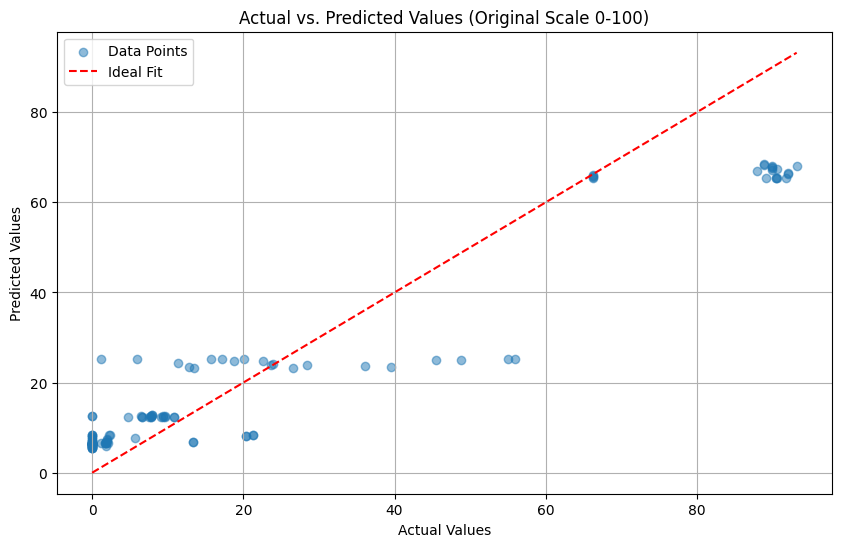

Test Metrics:
mse: 143.2737
mae: 9.3662
r2: 0.8532


In [ ]:
metrics = predictions_best_model(
    test_loader=test_loader, best_params=best_params, best_model_path='best/best_model.pth', 
    col_min=0, col_max=100)
    
print("Test Metrics:")
for name, value in metrics.items():
        print(f"{name}: {value:.4f}")